# Unsupervised Learning Methods
## Outline 
#### 1. Text similarity: cosine similarity, summary extraction
#### 2. Text clusttering: K-mean, visualization with PCA, t-SNE, MDS
#### 3. Build Recommender System

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import plotly.express as px

from scipy.stats import entropy
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS

import re
import string

In [8]:
# download and create the stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english')) | set(stopwords.words('french')) | set(stopwords.words('italian')) | set(stopwords.words('german')) | set(stopwords.words('portuguese')) | set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ymsc1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# get reviews and perform text vectorization

def get_reviews_vectorized(top_n=-1, ngram_range=(1, 1), max_features=1000):
    df = pd.read_pickle("asset/cleaned_reviews.pkl")
    df = df.dropna()
    df = df.groupby(['wine ID', 'year']).agg({
        'Review': lambda x : ' '.join(x),
        'name':'unique',
        'country':'unique', 
        'winery': 'unique',
        'price': 'unique',
        'rating': 'unique'
        })
    df.reset_index(inplace=True)
    df = df.astype("string")
    df[['price','rating']] = df[['price','rating']].apply(lambda x: x.str[1:-1])
    df[['name', 'country', 'winery']] = df[['name', 'country', 'winery']].apply(lambda x: x.str[2:-2])
    review_instances = df.Review.replace('\d+'," ", regex=True)
    review_instances = review_instances.replace(r'\n',' ', regex=True)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=max_features,
        min_df=10,
        stop_words=stopwords_list,
        ngram_range=ngram_range,
        use_idf=True,
    )
    if top_n >= 0:
        review_instances = review_instances.values[0:top_n]
        df = df[0:top_n]
    else:
        review_instances = review_instances.values


    X = vectorizer.fit_transform(review_instances)

    return (X, vectorizer, review_instances, df)

In [10]:
(X, vectorizer, review_instances, df) = get_reviews_vectorized(-1, (1, 2))

## 1. Text similarity

In [11]:
cosine_similarities = linear_kernel(X, X)

In [12]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []
    
    # Find the index of the input
    idx = indices[indices == name].index[0]
    
    # Find the wines with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])
    
    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])
    
    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))
    
    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new



def sample():
    select = df.sample(n=1)
    name = select['name'].item()
    print('Select %s ' % name)
    
    return select



def make_wordcloud(text):
    # Generate a word cloud image
    text = text
    wordcloud = WordCloud().generate(text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [13]:
select = sample()
select

Select Condrieu 2020 


wine ID  year                                             Review  \
4018  1100867  2020  Very good developing wine

Appearance: med lem...   

               name country           winery        price rating  
4018  Condrieu 2020  France  Pierre Gaillard  81.88049276    4.1

In [14]:
select_name = select.name.item()
recomendation = recommend(select_name)
recomendation

Top 10 wines like Condrieu 2020 with similar reviews: 


C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/1087452934.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))
C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/1087452934.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))
C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/1087452934.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))
C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/1087452934.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

country          winery         price  \
Condrieu Chery 2019                   France    André Perret  123.19516334   
Chante-Alouette Hermitage Blanc 2017  France   M. Chapoutier   53.38036077   
Vintage Tunina 2018                    Italy         Jermann   48.93199737   
Condrieu La Doriane 2019              France       E. Guigal   95.88694435   
La Rocca Soave Classico 2018           Italy        Pieropan   41.51805838   
Condrieu La Petite Côte 2020          France  Yves Cuilleron    73.5983574   
Condrieu Invitare  2019               France   M. Chapoutier    42.8525674   
Condrieu Invitare  2018               France   M. Chapoutier   51.20330978   
Chante-Alouette Hermitage Blanc 2018  France   M. Chapoutier   63.36409586   
Aspros Lagos White 2020               Greece     Douloufakis   22.48894829   

                                     rating  wine ID  year  \
Condrieu Chery 2019                     4.5  1103309  2019   
Chante-Alouette Hermitage Blanc 2017    4.4    20647  2017   
Vintage Tunina 2018                     4.3    79525  2018   
Condrieu La Doriane 2019                4.3  1318318  2019   
La Rocca Soave Classico 2018            4.2    22945  2018   
Condrieu La Petite Côte 2020            4.2    97916  2020   
Condrieu Invitare  2019                 4.2    20638  2019   
Condrieu Invitare  2018                 4.2    20638  2018   
Chante-Alouette Hermitage Blanc 2018    4.2    20647  2018   
Aspros Lagos White 2020                 4.2  1269170  2020   

                                                                                 Review  
Condrieu Chery 2019                   Translucent yellow. Seductively perfumed aroma...  
Chante-Alouette Hermitage Blanc 2017  94pts me 94RP 97WS

This is always my go to fo...  
Vintage Tunina 2018                   honeysuckle pineapple honey
peach citrus cream...  
Condrieu La Doriane 2019              "This is what Viognier is supposed to taste li...  
La Rocca Soave Classico 2018          @[1|47623479|Blind Faith] vertical tasting. I'...  
Condrieu La Petite Côte 2020          Lunch wine #2, seamless harmony with the chest...  
Condrieu Invitare  2019               Violet, tropical fruit, but not dominant in th...  
Condrieu Invitare  2018               Yellow apple, lychee, honey, anis, zest of ora...  
Chante-Alouette Hermitage Blanc 2018  Clear pale lemon in color with medium intensit...  
Aspros Lagos White 2020               A beautiful, creamy vidiano. White stone fruit...

This is the wordcloud of the select wine looks like...


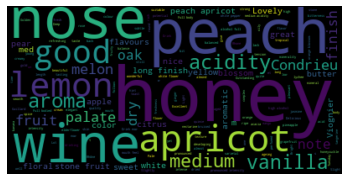

This is the wordcloud of the recommendation list looks like...


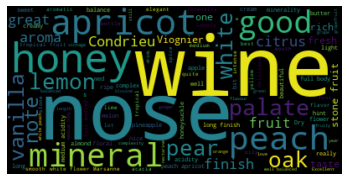

In [15]:
recomendation_review = ' '.join(recomendation.Review.tolist())
select_review = select.Review.item()
print('This is the wordcloud of the select wine looks like...')
make_wordcloud(select_review)
print('This is the wordcloud of the recommendation list looks like...')
make_wordcloud(recomendation_review)

## 2. Text clusttering

#### Firstly, try k-means by two categories.

In [16]:
def kmeans_review_k_2():
    result = None
   
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    features = vectorizer.get_feature_names()    
    sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]    
    top10_clust1 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[0]][:10]
    top10_clust2 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[1]][:10]
    result = [top10_clust1, top10_clust2]

    return result


kmeans_review_k_2()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[['apple',
  'citrus',
  'lemon',
  'champagne',
  'pear',
  'peach',
  'honey',
  'bubbles',
  'yellow',
  'brioche'],
 ['bordeaux',
  'merlot',
  'cabernet',
  'cab',
  'barolo',
  'brunello',
  'syrah',
  'rioja',
  'pinot',
  'sangiovese']]

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


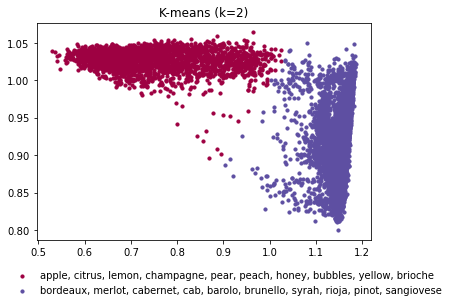

In [17]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
def scatter_plot():
    colors = cm.Spectral(np.linspace(0, 1, 2))
    cdict = {0: colors[0], 1: colors[1]}
    
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    X_km = km.transform(X_ar)
    y = km.fit_predict(X_ar)
    label1 = ', '.join(kmeans_review_k_2()[0])
    label2 = ', '.join(kmeans_review_k_2()[1])

    fig, ax = plt.subplots()
    for cls in np.unique(y):
        ix = np.where(y == cls)
        ax.scatter(X_km[ix, 0], X_km[ix, 1], color = cdict[cls], label = cls, s = 10)
    ax.legend((label1, label2), bbox_to_anchor=(-0.1, -0.1), loc='upper left', frameon=False)
    ax.set_title('K-means (k=2)')
    plt.show()


scatter_plot()

In [18]:
', '.join(kmeans_review_k_2()[0])

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'apple, citrus, lemon, champagne, pear, peach, honey, bubbles, yellow, brioche'

In [20]:
def km_2_by_plotly(X, title):
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    X_km = km.transform(X_ar)
    y = km.fit_predict(X_ar)

    labels = [', '.join(wd) for wd in np.array(kmeans_review_k_2())[y]] 
    df_km = pd.DataFrame(X_km, columns=['x', 'y'])
    df_km['labels'] = labels
    df_plot = pd.concat([df_km, df], axis=1)


    fig = px.scatter(
    df_plot, x='x', y='y',
    color='labels', title=title, 
    hover_data=['name', 'country', 'winery', 'price', 'rating']
    )
    fig.write_html("plotly/%s.html" % title)
    fig.show()

km_2_by_plotly(X, 'K-means')

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



#### Interesting! It seems the k-means finds two discrete categories, the "red" and the "white"! There are more categories for wines! <br>We want to explore the optimal number of clusters using the elbow method. 

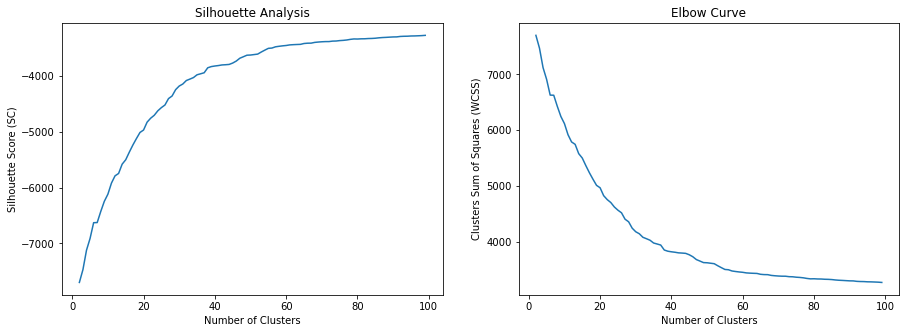

In [21]:
# elbow curve for exploring k values for KNN
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
X_ar = X.toarray()
Nc = range(2, 100)

kmeans = [KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, random_state=42) for i in Nc]
sc = [kmeans[i].fit(X_ar).score(X_ar) for i in range(len(kmeans))]
wcss = [kmeans[i].fit(X_ar).inertia_ for i in range(len(kmeans))]



axes[0].plot(Nc,sc)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score (SC)')
axes[0].set_title('Silhouette Analysis')

axes[1].plot(Nc,wcss)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Clusters Sum of Squares (WCSS)')
axes[1].set_title('Elbow Curve')


plt.show()

#### The optimal number of clustters is near 30. We set k=30 for the K-means. <br>Next, we want create labels for each cluster by extracting discrete words in the reviews of each wine.

In [22]:
def compute_distinctive_term_score(T, T_a):
    # First compute information gain.
    IG = entropy(T) - entropy(T_a)

    # if it's high IG, but not for this class, we want to penalize,
    # so flip the IG negative.  We do this because these are terms those whose *absence* is notable,
    # but we don't care about those for purposes of this assignment and so we give them
    # a score that guarantees we won't rank them highly.
    if T_a[0] < T_a[1]:
        score = -IG
    else:
        score = IG
    return score


# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index + 1 :, :])).sum(axis=0)

    result = np.vstack((row0, row1))
    return result

In [23]:
def answer_cluster_labeling(n_clusters=7):
    result = None

    X_ar = X.toarray()
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    ig = np.empty([n_clusters, 1000])
    for c in range(n_clusters):
        tc = one_vs_all_count_matrix(centroids, c).sum(axis=1)/one_vs_all_count_matrix(centroids, c).sum(axis=1).sum(axis=0)
        for w in range(1000):
            tw = one_vs_all_count_matrix(centroids, c)[:,w]/one_vs_all_count_matrix(centroids, c).sum(axis=0)[w]
            ig[c,w] = compute_distinctive_term_score(tc, tw)
    features = vectorizer.get_feature_names()    
    sorted_ig_idx = ig.argsort(axis=1)[:,::-1] 
    result = []
    for c in range(n_clusters):
        result.append([features[feature_idx] for feature_idx in sorted_ig_idx[c]][:5])
    return result


answer_cluster_labeling(30)

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



[['bubbly', 'brut', 'fine bubbles', 'bubbles', 'sparkling'],
 ['cab', 'cabernet', 'valley', 'sauv', 'cabernet sauvignon'],
 ['biscuit', 'bubbly', 'yeasty', 'yeast', 'sparkling'],
 ['tuscan', 'super tuscan', 'italian', 'friday', 'pizza'],
 ['tempranillo', 'modern', 'coconut', 'american', 'spanish'],
 ['passion fruit', 'gooseberry', 'blanc', 'white wine', 'lychee'],
 ['grenache', 'lavender', 'syrah', 'white pepper', 'olive'],
 ['grape', 'italy', 'south', 'light bodied', 'pizza'],
 ['friday',
  'sangiovese',
  'leather cherry',
  'cherry tobacco',
  'cherry leather'],
 ['grenache', 'spanish', 'spain', 'slate', 'vines'],
 ['left bank', 'chateau', 'second wine', 'grand cru', 'nd'],
 ['spain', 'spanish', 'reserva', 'american', 'coconut'],
 ['saint', 'grand cru', 'st', 'grand', 'bank'],
 ['walnut', 'apricots', 'nutty', 'toffee', 'caramel'],
 ['raisin', 'raisins', 'dried fruit', 'cherry chocolate', 'prune'],
 ['sangiovese', 'pizza', 'tomato', 'pasta', 'friday'],
 ['olive', 'grenache', 'france'

In [24]:
def answer_manifold_a():
    result = None

    # YOUR CODE HERE
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)

    pca = PCA(n_components=2, random_state = 42)
    X_pca = pca.fit_transform(X_ar)
    
    tsne = TSNE(n_components=2, random_state = 42)
    X_tsne = tsne.fit_transform(X_ar)
    
    mds = MDS(n_components=2, random_state = 42)
    X_mds = mds.fit_transform(X_ar)

    result = (X_pca, X_tsne, X_mds)
    return result

X_pca, X_tsne, X_mds = answer_manifold_a()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



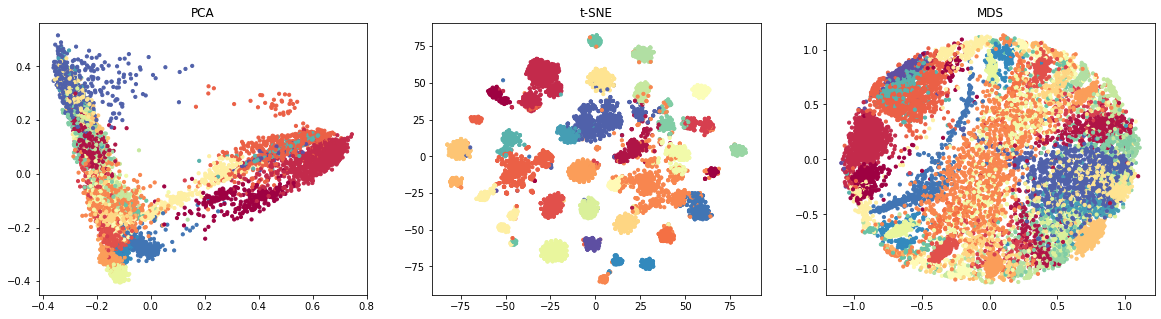

In [25]:
def plot_manifolds():
    colors = cm.Spectral(np.linspace(0, 1, 30))
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[y])
    axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, color=colors[y])
    axes[2].scatter(X_mds[:, 0], X_mds[:, 1], s=10, color=colors[y])

    axes[0].set_title("PCA")
    axes[1].set_title("t-SNE")
    axes[2].set_title("MDS")
    plt.show()

plot_manifolds()

#### Same visualizations build on Plotly. Enjoy the interactive experiences!

In [26]:
def scatterplot_by_plotly(X, manifolds, title):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_manifolds = pd.DataFrame(manifolds, columns=['x', 'y'])
    df_manifolds['labels'] = labels
    df_plot = pd.concat([df_manifolds, df], axis=1)


    fig = px.scatter(
    df_plot, x='x', y='y',
    color='labels', title=title, 
    hover_data=['name', 'country', 'winery', 'price', 'rating']
    )
    fig.write_html("plotly/%s.html" % title)
    fig.show()

In [27]:
scatterplot_by_plotly(X, X_pca, "PCA")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [28]:
scatterplot_by_plotly(X, X_tsne, "t-SNE")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [29]:
scatterplot_by_plotly(X, X_mds, "MDS")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



## 3. Build Recommender System

In [30]:
def recommend_knn(name):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_knn = df.copy()
    df_knn['labels'] = labels

    select_label = df_knn[df_knn.name == name].sample(n=1)['labels']
    df_new = df_knn[df_knn.labels == select_label]
    
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new

In [31]:
def get_mean_vector(wine_list):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)
    vectors = []
    
    for wine in wine_list:
        idx = indices[indices == wine].index[0]
        vector = km.transform(X_ar[idx].reshape(1, -1))
        vectors.append(vector)  
    
    song_matrix = np.array(list(vectors))
    return np.mean(song_matrix, axis=0)




def recommend_knn(wine_list):
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)

    # Find the wines with a similar cosine-sim value and order them from bigges number
    wine_center = get_mean_vector(wine_list).reshape(1, -1)
    wine_data = km.transform(X_ar)

    distances = cdist(wine_center, wine_data, 'cosine')

    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(np.argsort(distances)[:, :30][0])


    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])

    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])

    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))

    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)

    print('Top wines with similar reviews according to the user list: ')

    return df_new




def sample_list(n=5):
    select = df.sample(n)
    for i in range(n):
        name = select.name.iloc[i]
        print('Select %s ' % name)
    
    return select

In [32]:
user_sample = sample_list(5)
user_list = user_sample.name.tolist()
user_sample

Select Emilín Moscatel Sherry (Solera Reserva) N.V. 
Select Chianti Classico 2013 
Select Special Cuvée Sauvignon Blanc 2020 
Select Les Allées de Cantemerle Haut-Médoc 2015 
Select Moulin de La Lagune Haut-Médoc 2015 


wine ID  year                                             Review  \
5554  1170132  N.V.  Delicious, full of orange zest, ripe figs, but...   
1031    13795  2013  4.1🌟 One more find during my stock inventory. ...   
1887    35474  2020  Tropical fruit on nose. Cranberry, gooseberry ...   
4380  1127929  2015  Very good second wine of Cantemerle in a great...   
5663  1173064  2015  Wood, wet leaves, wilted roses , forest floor,...   

                                              name       country  \
5554  Emilín Moscatel Sherry (Solera Reserva) N.V.         Spain   
1031                         Chianti Classico 2013         Italy   
1887            Special Cuvée Sauvignon Blanc 2020  South Africa   
4380      Les Allées de Cantemerle Haut-Médoc 2015        France   
5663           Moulin de La Lagune Haut-Médoc 2015        France   

                  winery        price rating  
5554              Lustau  23.62575227     4.  
1031            Cafaggio  79.08201596    3.7  
1887  Springfield Estate  23.57632601     4.  
4380  Château Cantemerle  64.86558473    3.8  
5663   Château La Lagune  23.72460479    4.2

In [33]:
recomendation_list = recommend_knn(user_list)
recomendation_list

Top wines with similar reviews according to the user list: 


C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/3222903887.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/3222903887.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/3222903887.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/3222903887.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ymsc1\AppData\Local\Temp/ipykernel_10692/3222903887.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

country                   winery  \
Tinto 2012                               Spain  Espectacle del Montsant   
Petit Verdot 2015                        Spain          Abadía Retuerta   
Luminaria Primitivo di Manduria 2019     Italy               Puglia Pop   
Platón Tinto 2019                        Spain        Divina Proporción   
Carrocel 2011                         Portugal        Quinta da Pellada   
Parcela Única Tannat B26 2017          Uruguay                    Bouza   
Altos de Losada El Cepón 2017            Spain                   Losada   
Tinto 2012                            Portugal          Quinta do Mouro   
Tinto 2012                            Portugal                  Mouchão   
Grande Reserva 2015                   Portugal           Herdade Grande   

                                             price rating  wine ID  year  \
Tinto 2012                            147.29025472    4.5  1171308  2012   
Petit Verdot 2015                     111.45621624    4.5    73592  2015   
Luminaria Primitivo di Manduria 2019   24.66370373    4.4  9348311  2019   
Platón Tinto 2019                       24.5055397    4.4  9944599  2019   
Carrocel 2011                          93.90989395    4.4  1328493  2011   
Parcela Única Tannat B26 2017          36.57543238    4.4  4807457  2017   
Altos de Losada El Cepón 2017          35.48805466    4.3  7088812  2017   
Tinto 2012                              79.0325897    4.3  1133074  2012   
Tinto 2012                             39.52123748    4.3    76439  2012   
Grande Reserva 2015                    29.16149338    4.3  6816983  2015   

                                                                                 Review  
Tinto 2012                            Exceptional Grenache blind tasting. Third flig...  
Petit Verdot 2015                     100% Petit Verdot! And what a glass. Complex f...  
Luminaria Primitivo di Manduria 2019  Rich, red fruit but not thrown off balance by ...  
Platón Tinto 2019                     Es un vino potente y de buena estructura. De c...  
Carrocel 2011                         Impressive! You can tell its an Alvaro de Cast...  
Parcela Única Tannat B26 2017         Amazing wine Very well made class.
Beautiful n...  
Altos de Losada El Cepón 2017         4,3/5 Complex but fresh, creamy, full-body- Me...  
Tinto 2012                            Good and rather Alentejo.Good vintage,well bal...  
Tinto 2012                            Very intense. Dark colour, medium to high acid...  
Grande Reserva 2015                   This is dark,inky gorgeous bottle of Alentejo ...

This is the wordcloud of the user list looks like...


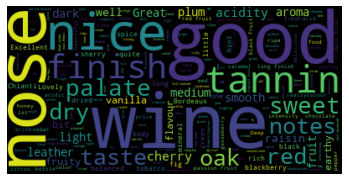

This is the wordcloud of the recommendation list looks like...


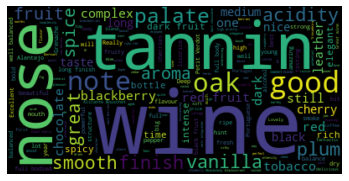

In [34]:
user_sample_1_review = ' '.join(user_sample.Review.tolist())
print('This is the wordcloud of the user list looks like...')
make_wordcloud(user_sample_1_review)
recomendation_list_review = ' '.join(recomendation_list.Review.tolist())
print('This is the wordcloud of the recommendation list looks like...')
make_wordcloud(recomendation_list_review)